# Image Based Cell Phenotyping Using ResNet

## Import Dependencies

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch.nn.functional as F 
import boto3
import cv2

In [70]:
!pip install tqdm


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [79]:
from tqdm import tqdm

## Define S3 config for training data

In [4]:
s3 = boto3.resource('s3')
client = boto3.client('s3')
ml_bucket = s3.Bucket('mlbucket-876f4491')

## Utility Function for importing S3 data locally

In [5]:
# Commented out since its only needed for initial setup
#i = 0
#for objects in ml_bucket.objects.filter(Prefix="cell-analysis-processed/test/U2OS/"):
#    print(str(objects.key))
#    obj = str(objects.key)
#    client.download_file('mlbucket-876f4491', obj, obj)
#    i+=1
#    if i > 1:
#        break

# Utility Functions for Data Exploration

In [52]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['HCT-116', 'HL60', 'JURKAT', 'LNCAP', 'MCF7', 'PC3', 'THP-1', 'U2OS']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [7]:
def normalizeImage(path: str) -> torch.Tensor:
        img = cv2.imread(path)
        img_tensor = torch.tensor(img, dtype= torch.float)
        return (img_tensor - img_tensor.mean([0, 1])) / img_tensor.std([0, 1])

In [8]:
normalized_image = normalizeImage('cell-analysis-processed-images-4channels/train/HCT-116/HCT-116_10.png')

In [9]:
normalized_image.shape

torch.Size([244, 244, 3])

In [10]:
pip install slideio


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import slideio
from matplotlib import pyplot as plt

path='cell-analysis-processed-images-4channels/train/HCT-116/HCT-116_10.png'
slide = slideio.open_slide(path, "GDAL")
scene = slide.get_scene(0)
image = scene.read_block(channel_indices=[0])

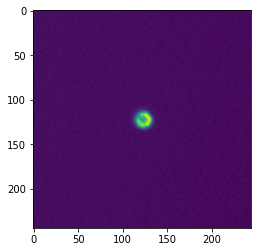

In [14]:
plt.imshow(image)

In [48]:
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   [(0.0,  0.0, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'blue':  [(0.0,  0.0, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  1.0, 1.0)]}

cmap = LinearSegmentedColormap("rgb", cdict)

plt.imshow(image[:,:,1], cmap=cmap)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

# Prepare Data for Model Training

In [64]:
from sagemaker import get_execution_role
role = get_execution_role()

### Start Processing Job for Training Set

In [ ]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

processor = Processor(base_job_name='image-analysis',
                    image_uri='463045133778.dkr.ecr.us-east-1.amazonaws.com/tf-1.5-py3-image-analysis:latest',
                     role=role,
                     instance_count=1,
                     instance_type="ml.m5.24xlarge",
                     volume_size_in_gb=500)

processor.run(inputs=[ProcessingInput(
                        source='s3://mlbucket-876f4491/cell-analysis-data/Train',
                        destination='/opt/ml/processing/input')],
                    outputs=[ProcessingOutput(
                        source='/opt/ml/processing/output',
                        destination='s3://mlbucket-876f4491/cell-analysis-processed-images/train')],
                    )

### Start Processing Job for Validation Set

In [ ]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

processor = Processor(base_job_name='image-analysis-test',
                    image_uri='463045133778.dkr.ecr.us-east-1.amazonaws.com/tf-1.5-py3-image-analysis:latest',
                     role=role,
                     instance_count=1,
                     instance_type="ml.g4dn.16xlarge",
                     volume_size_in_gb=500)

processor.run(inputs=[ProcessingInput(
                        source='s3://mlbucket-876f4491/cell-analysis-data/Test',
                        destination='/opt/ml/processing/input')],
                    outputs=[ProcessingOutput(
                        source='/opt/ml/processing/output',
                        destination='s3://mlbucket-876f4491/cell-analysis-processed-images/test')],
                    )

# Define the PyTorch DataSet for Training input

In [20]:
from torchvision import transforms as T,datasets
import glob
from torch.utils.data import Dataset, DataLoader
import random

In [31]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, dim, channels, transform=None, TotalSamples=100):
        self.root_dir = root_dir
        self.transform = transform
        file_list = glob.glob(self.root_dir + "*")
        #print(file_list)
        self.data = []
        self.datashape=(dim,dim,channels)
        self.TotalSamples=TotalSamples

        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for file_path in glob.glob(class_path + "/*.pickle"):
                #data.append([file_path, class_name])
                #print(file_path)
                x = pickle.load(open(file_path,"rb"))
                x = tf.keras.utils.normalize(x)
                size = x.shape
                #print(size)
                for image in range(size[0]):
                    im = [x[image].astype(float)]
                    im = np.array(im)
                    im = im.squeeze()  
                    if im.shape == self.datashape:
                        self.data.append([im, class_name])
        self.data = self.format_data(True)
        #print(self.data)

        self.class_map = {'HCT-116': 0, 'HL60': 1, 'JURKAT': 2, 'LNCAP': 3, 'MCF7': 4, 'PC3': 5, 'THP-1': 6, 'U2OS': 7}
        self.img_dim = (dim, dim)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, class_name = self.data[idx]
        #img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        #class_id = torch.tensor([class_id])
        #return img_tensor, class_id
        return img_tensor.float(), class_id
    
    def class_to_idx(self):
        return print(self.class_map)
    
    #Balance the classes so that they are of equal lengths
    #dataset is a list of [image, label]
    def format_data(self, augment):
        dataset = self.data
        classes = dict([])
        class_index = []
        data = []
        X = []
        y = []
        dataset_new=[]
        reverse_class_map = {0:'HCT-116' , 1:'HL60', 2:'JURKAT', 3:'LNCAP', 4:'MCF7', 5:'PC3', 6:'THP-1', 7:'U2OS'}
        for x in dataset:
            # check if exists in unique_list or not 
            if x[1] not in list(classes.keys()):
                classes[x[1]] = 1
            else:
                classes[x[1]] = classes[x[1]] + 1
            class_index.append(x[1])
            data.append(x[0])
        #print(classes.items())

        if augment == True:
            for item in list(classes.keys()):
                indicies = [i for i, x in enumerate(class_index) if x == item] 
                if len(indicies) >= self.TotalSamples:
                    indicies = random.sample(indicies, k = self.TotalSamples)
                    for i in indicies:
                        #X.append(data[i])
                        #y.append(class_index[i])
                        #class_name = reverse_class_map[class_index[i]]
                        dataset_new.append([data[i],class_index[i]])
                else:
                    aug = []
                    for i in indicies:
                        #class_name = reverse_class_map[class_index[i]]
                        dataset_new.append([data[i],class_index[i]])
                        #X.append(data[i])
                        #y.append(class_index[i])
                        aug.append(data[i])
                    new_data = self.data_augmentation(aug)
                    for i in range(len(new_data)):
                        #X.append(new_data[i])
                        #y.append(class_index[indicies[0]])
                        #class_name = reverse_class_map[class_index[i]]
                        dataset_new.append([data[i],class_index[i]])
        else:
             for item in list(classes.keys()):
                    indicies = [i for i, x in enumerate(class_index) if x == item]
                    for i in indicies:
                        #X.append(data[i])
                        #y.append(class_index[i])
                        #class_name = reverse_class_map[class_index[i]]
                        dataset_new.append([data[i],class_index[i]])
        return dataset_new
    ##Rotational data augmentation
    def data_augmentation(self, data):
        new_data = []

        for i in range(self.TotalSamples-len(data)):
            new_image = data[random.randint(1,len(data)-1)]
            for r in range(random.randint(1,3)):
                new_image = np.rot90(new_image)
            new_data.append(new_image)
        return new_data

# Load Dataset for loca debugging and training

In [22]:
!pip install tensorflow


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import pickle
import tensorflow as tf

## Load Training Data

In [32]:
train_path="cell-analysis-processed/train/"
trainset = CustomDataset(root_dir=train_path, dim=244, channels=4, TotalSamples=1000)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  8000


In [25]:
trainset.class_to_idx()

{'HCT-116': 0, 'HL60': 1, 'JURKAT': 2, 'LNCAP': 3, 'MCF7': 4, 'PC3': 5, 'THP-1': 6, 'U2OS': 7}


## Load Validation Data

In [33]:
val_path="cell-analysis-processed/val/"
validateset = CustomDataset(root_dir=val_path, dim=244, channels=4, TotalSamples=100)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  800


In [34]:
validateset.class_to_idx()

{'HCT-116': 0, 'HL60': 1, 'JURKAT': 2, 'LNCAP': 3, 'MCF7': 4, 'PC3': 5, 'THP-1': 6, 'U2OS': 7}


## Load Test Data

In [36]:
test_path="cell-analysis-processed/test/"
testset = CustomDataset(root_dir=test_path, dim=244, channels=4, TotalSamples=100)
print("testset Size:  {}".format(len(testset)))

testset Size:  800


In [37]:
testset.class_to_idx()

{'HCT-116': 0, 'HL60': 1, 'JURKAT': 2, 'LNCAP': 3, 'MCF7': 4, 'PC3': 5, 'THP-1': 6, 'U2OS': 7}


# Initiate the Data Loaders

In [42]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [43]:
trainloader = DataLoader(trainset,batch_size=16,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:500
No. of Total examples:8000


In [44]:
validationloader = DataLoader(validateset,batch_size=16,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:50
No. of Total examples:800


In [45]:
testloader = DataLoader(testset,batch_size=16,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:50
No. of Total examples:800


# Define Model for Training

In [53]:
!pip install timm # install PyTorch Image Models


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [54]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models
import torchvision.models as models

#model_name = 'resnet50'
#model = timm.create_model(model_name,pretrained=True, in_chans=4) #load pretrained model
model = models.resnet50(pretrained=False)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Modify first layer to expect 4 input channels

In [55]:
model.conv1 = torch.nn.Conv2d(4,64,kernel_size = (7,7),stride = (2,2), padding = (3,3), bias = False) 

### Update the output layer as a 8-class classifier

In [56]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=625), #1280 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=8), 
)

In [57]:
model

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
!pip install torchsummary


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [61]:
from torchsummary import  summary
model.to(device) # move the model to GPU

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
## Uninstalling SM Debugger as it was throwing errors
!pip uninstall smdebug -y

In [62]:
summary(model,input_size=(4,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]          12,544
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

### Define the Model Trainer
(For Local Model Training & Debugging)

In [76]:
class CellPhenotypingTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

trainer = CellPhenotypingTrainer(criterion,optimizer)

In [ ]:
trainer.fit(model,trainloader,validationloader,epochs = 20)

100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


Valid_loss decreased inf --> 3.220642261505127
Epoch : 1 Train Loss : 1.399543 Train Acc : 0.511375
Epoch : 1 Valid Loss : 3.220642 Valid Acc : 0.077500


100%|██████████| 50/50 [00:03<00:00, 15.56it/s]


Valid_loss decreased 3.220642261505127 --> 0.7879193931818008
Epoch : 2 Train Loss : 0.765227 Train Acc : 0.724500
Epoch : 2 Valid Loss : 0.787919 Valid Acc : 0.801250


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Epoch : 3 Train Loss : 0.565257 Train Acc : 0.800375
Epoch : 3 Valid Loss : 0.858156 Valid Acc : 0.751250


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Epoch : 4 Train Loss : 0.483673 Train Acc : 0.829875
Epoch : 4 Valid Loss : 1.115660 Valid Acc : 0.822500


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


Epoch : 5 Train Loss : 0.431156 Train Acc : 0.843625
Epoch : 5 Valid Loss : 2.142079 Valid Acc : 0.523750


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


Epoch : 6 Train Loss : 0.360829 Train Acc : 0.873250
Epoch : 6 Valid Loss : 1.456295 Valid Acc : 0.681250


100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


Epoch : 7 Train Loss : 0.317531 Train Acc : 0.885750
Epoch : 7 Valid Loss : 2.133921 Valid Acc : 0.603750


100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


Epoch : 8 Train Loss : 0.270995 Train Acc : 0.903625
Epoch : 8 Valid Loss : 1.916670 Valid Acc : 0.571250


100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


Epoch : 9 Train Loss : 0.237823 Train Acc : 0.915625
Epoch : 9 Valid Loss : 1.507813 Valid Acc : 0.692500


100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


Epoch : 10 Train Loss : 0.202348 Train Acc : 0.931875
Epoch : 10 Valid Loss : 1.701967 Valid Acc : 0.703750


100%|██████████| 50/50 [00:03<00:00, 16.23it/s]


Epoch : 11 Train Loss : 0.188956 Train Acc : 0.938875
Epoch : 11 Valid Loss : 1.373835 Valid Acc : 0.777500


100%|██████████| 50/50 [00:03<00:00, 16.39it/s]


Epoch : 12 Train Loss : 0.159958 Train Acc : 0.946625
Epoch : 12 Valid Loss : 1.469220 Valid Acc : 0.632500


100%|██████████| 50/50 [00:03<00:00, 16.37it/s]


Epoch : 13 Train Loss : 0.147224 Train Acc : 0.950250
Epoch : 13 Valid Loss : 0.984403 Valid Acc : 0.775000


100%|██████████| 50/50 [00:03<00:00, 16.20it/s]


Epoch : 14 Train Loss : 0.125723 Train Acc : 0.959375
Epoch : 14 Valid Loss : 1.464469 Valid Acc : 0.740000


100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


Epoch : 15 Train Loss : 0.127931 Train Acc : 0.958375
Epoch : 15 Valid Loss : 2.801936 Valid Acc : 0.528750


100%|██████████| 50/50 [00:03<00:00, 16.44it/s]


Epoch : 16 Train Loss : 0.115390 Train Acc : 0.963000
Epoch : 16 Valid Loss : 1.408434 Valid Acc : 0.751250


100%|██████████| 50/50 [00:03<00:00, 16.37it/s]


Epoch : 17 Train Loss : 0.098042 Train Acc : 0.968375
Epoch : 17 Valid Loss : 2.475245 Valid Acc : 0.682500


 84%|████████▍ | 420/500 [01:23<00:15,  5.10it/s]

# Set Up SageMaker Training Job

## Define Input Channels

In [ ]:
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(s3_data="s3://mlbucket-876f4491/cell-analysis-processed/train", input_mode="FastFile")
test_input = TrainingInput(s3_data="s3://mlbucket-876f4491/cell-analysis-processed/test", input_mode="FastFile")
inputs = {
    "training": train_input,
    "testing": test_input
}

## Initiate Training Job

In [ ]:
from sagemaker.pytorch import PyTorch

icp_estimator = PyTorch(entry_point='resnet_ddp.py',
                         source_dir = './source',
                            role=role,
                            framework_version='1.11.0',
                            py_version='py38',
                            train_instance_count=1,
                            train_instance_type='ml.p3.16xlarge',
                            volume_size = 500,
                            max_run = (24 * 60 * 60),
                            hyperparameters = {'epochs': 20, 'batch_size': 32, 'lr': 1e-4},
                            metric_definitions=[
                                {'Name': 'Train: Loss', "Regex": "Train Loss:(.*?);"},
                                {'Name': 'Train: Accuracy', "Regex": "Train Acc:(.*?);"},
                                {'Name': 'Validation: Loss', "Regex": "Valid Loss:(.*?);"},
                                {'Name': 'Validation: Accuracy', "Regex": "Valid Acc:(.*?);"}
                            ],
                            enable_sagemaker_metrics=True,
                        distribution={"smdistributed": {"dataparallel": {"enabled": True}}},
                        debugger_hook_config=False
                        )
icp_estimator.fit(inputs)